# Potencial $V(x) = |x|$ — Numerov vs Diferencias Finitas

Se resuelve la ecuación de Schrödinger estacionaria en unidades naturales ($\hbar^2/2m = 1$):

$$-\psi'' + |x|\,\psi = E\,\psi$$

en el dominio $[-5, 5]$ con condiciones de frontera $\psi(\pm 5) = 0$.

Los autovalores exactos son los ceros de la función de Airy (dominio infinito):
$$E_n^{\text{exacto}} \approx 1.019,\; 2.338,\; 3.248,\; 4.088,\; 4.820,\; 5.521 \dots$$


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import subprocess, os

# Obtener la carpeta del notebook (compatible con VS Code Jupyter)
_nb_path = globals().get("__vsc_ipynb_file__", None)
if _nb_path:
    WORKDIR = os.path.dirname(os.path.abspath(_nb_path))
else:
    WORKDIR = os.path.abspath("2.EDOs/taller-numerov2")

os.chdir(WORKDIR)
print("Directorio de trabajo:", os.getcwd())


Directorio de trabajo: /home/isabel/MFC/2.EDOs/taller-numerov2


## 1. Diferencias Finitas (Fortran)

Se discretiza el Hamiltoniano en una malla de $N$ puntos. La derivada segunda se aproxima como:

$$\psi_i'' \approx \frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{h^2}$$

lo que convierte la EDO en el problema de eigenvalores tridiagonal $H\vec{\psi} = \lambda\vec{\psi}$, con:

$$H_{ii} = \frac{2}{h^2} + |x_i|, \qquad H_{i,i\pm 1} = -\frac{1}{h^2}$$

Diagonalizado con el algoritmo de Householder–QL (`diagotri`).


In [16]:
# ── Escribir fuentes Fortran ──────────────────────────────────────────────────
diagotri_src = """\
SUBROUTINE diagotri(d,e,N,z,vectors)
  IMPLICIT NONE
  INTEGER,INTENT(IN)::N
  REAL(8),INTENT(INOUT)::d(N),e(N),z(N,N)
  LOGICAL,INTENT(IN)::vectors
  integer::i,iter,l,m
  real(8)::b,c,dd,f,g,p,r,s,pythag,ff(N)
  e(:)=eoshift(e(:),1)
  do l=1,N
     iter=0
     ITERATE: do
        do m=l,N-1
           dd=abs(d(m))+abs(d(m+1))
           if(abs(e(m))+dd.eq.dd)EXIT
        enddo
        if(m.eq.l) EXIT ITERATE
        if(iter.eq.30)then; write(6,*)'no converge'; stop; end if
        iter=iter+1
        g=(d(l+1)-d(l))/(2.d0*e(l)); r=pythag(g,1.d0)
        g=d(m)-d(l)+e(l)/(g+sign(r,g))
        s=1.d0; c=1.d0; p=0.d0
        do i=m-1,l,-1
           f=s*e(i); b=c*e(i); r=pythag(f,g); e(i+1)=r
           if(r.eq.0.d0)then; d(i+1)=d(i+1)-p; e(m)=0.d0; CYCLE ITERATE; endif
           s=f/r; c=g/r; g=d(i+1)-p; r=(d(i)-g)*s+2.d0*c*b
           p=s*r; d(i+1)=g+p; g=c*r-b
           if(vectors)then
              ff(:)=z(:,i+1); z(:,i+1)=s*z(:,i)+c*ff(:); z(:,i)=c*z(:,i)-s*ff(:)
           end if
        end do
        d(l)=d(l)-p; e(l)=g; e(m)=0.d0
     enddo ITERATE
  enddo
END SUBROUTINE diagotri
REAL(8) FUNCTION pythag(a,b)
  REAL(8)::a,b,absa,absb
  absa=abs(a); absb=abs(b)
  if(absa.gt.absb)then; pythag=absa*sqrt(1.+(absb/absa)**2)
  else
     if(absb.eq.0.d0)then; pythag=0.d0
     else; pythag=absb*sqrt(1.d0+(absa/absb)**2); end if
  end if
END FUNCTION pythag
"""

fd_src = """\
PROGRAM PotAbs
  implicit none
  integer::i,j,N,Nf
  real(8),allocatable::A(:,:),d(:),e(:),tem(:)
  real(8)::h,xi,h_2
  N=50; Nf=1000
  do while(N.le.Nf)
     h=10.d0/N; h_2=1.d0/h**2
     allocate(A(N,N),d(N),e(N),tem(N))
     A=0.d0; d=0.d0; e=0.d0
     do i=1,N
        xi=-5.d0+i*h
        d(i)=2.d0*h_2+dabs(xi)
        e(i)=-h_2
        A(i,i)=1.d0
     end do
     call diagotri(d,e,N,A,.true.)
     do i=1,N
        do j=i+1,N
           if(d(j).lt.d(i))then
              xi=d(i); d(i)=d(j); d(j)=xi
              tem(:)=A(:,i); A(:,i)=A(:,j); A(:,j)=tem(:)
           end if
        end do
     end do
     write(6,"(i5,6(2x,F10.6))")N,d(1:6)
     if(N.ge.Nf/2)then
        open(unit=1,file="data_abs_fd")
        write(1,"('# N=',i5,2x,6(F12.8,1x))")N,d(1:6)
        tem=0.d0
        do i=1,N; tem(:)=tem(:)+A(i,:)**2; end do
        tem=h*tem
        do i=1,N
           xi=-5.d0+i*h
           write(1,"(7(F12.7,1x))")xi,A(i,1:6)**2/tem(i)
        enddo
        close(1)
     end if
     deallocate(A,d,e,tem)
     N=2*N
  end do
END PROGRAM PotAbs
"""

with open("diagotri.f90", "w") as f: f.write(diagotri_src)
with open("pot_abs_fd.f90", "w") as f: f.write(fd_src)

# Compilar
r = subprocess.run("gfortran pot_abs_fd.f90 diagotri.f90 -o pot_abs_fd -O2",
                   shell=True, capture_output=True, text=True)
print("✓ Compilado" if r.returncode == 0 else f"✗ Error:\n{r.stderr}")


✓ Compilado


In [17]:
# ── Ejecutar y cargar resultados FD ──────────────────────────────────────────
r = subprocess.run("./pot_abs_fd", shell=True, capture_output=True, text=True)
print(r.stdout)

# Leer energías del header y funciones de onda del archivo
with open("data_abs_fd") as f:
    header = f.readline()
E_fd = np.array([float(v) for v in header.strip().lstrip("#").split()[2:8]])

data_fd = np.loadtxt("data_abs_fd")
x_fd    = data_fd[:, 0]
psi2_fd = data_fd[:, 1:7]   # |ψ_n|²

print("\nEnergías FD:", np.round(E_fd, 6))


   50    1.014144    2.335175    3.248989    4.136088    5.016555    6.045077
  100    1.017647    2.338007    3.256484    4.151777    5.052701    6.114826
  200    1.018516    2.338751    3.258729    4.157622    5.067110    6.143088
  400    1.018733    2.338956    3.259483    4.160042    5.073364    6.155453
  800    1.018788    2.339016    3.259769    4.161126    5.076248    6.161180


Energías FD: [1.018788 2.339016 3.259769 4.161126 5.076248 6.16118 ]


## 2. Método de Numerov (Python)

La ecuación de Schrödinger se reescribe como $\psi'' + k^2(x)\,\psi = 0$ con $k^2(x) = E - V(x)$.

La recurrencia de Numerov avanza $\psi$ con error $O(h^6)$:

$$\psi_{i+1} = \frac{2\!\left(1 - \tfrac{5}{12}h^2 k^2_i\right)\psi_i \;-\; \left(1 + \tfrac{1}{12}h^2 k^2_{i-1}\right)\psi_{i-1}}{1 + \tfrac{1}{12}h^2 k^2_{i+1}}$$

Los autovalores se localizan barriendo $E$ y detectando cambios de signo en $\psi(5)$; cada cero se refina con **bisección**.

In [21]:
_trapz = getattr(np, "trapezoid", None) or np.trapz  # compatible NumPy ≥1 y ≥2

def numerov(E, x, V):
    """
    Integra ψ con el método de Numerov para ψ'' + k²(x)ψ = 0,  k²= E - V.
    Condición inicial: ψ[0]=0, ψ[1]=1e-6 (disparo desde el borde izquierdo).
    """
    h  = x[1] - x[0]
    k2 = E - V          # k²(x) = E - V(x)
    c  = h**2 / 12.0
    n  = len(x)
    psi = np.zeros(n)
    psi[1] = 1e-6
    for i in range(1, n - 1):
        psi[i+1] = (2*(1 - 5*c*k2[i])*psi[i] - (1 + c*k2[i-1])*psi[i-1]) / (1 + c*k2[i+1])
    return psi

def biseccion(E1, E2, x, V, tol=1e-10):
    f1 = numerov(E1, x, V)[-1]
    while abs(E2 - E1) > tol:
        Em = 0.5*(E1 + E2)
        fm = numerov(Em, x, V)[-1]
        if fm * f1 < 0:
            E2 = Em
        else:
            E1, f1 = Em, fm
    return 0.5*(E1 + E2)

# ── Malla y potencial ─────────────────────────────────────────────────────────
x_num = np.linspace(-5, 5, 3000)
V_num = np.abs(x_num)

# ── Barrido para localizar ceros de ψ(5) ─────────────────────────────────────
E_scan  = np.linspace(0.0, 15.0, 8000)
psi_end = np.array([numerov(E, x_num, V_num)[-1] for E in E_scan])

E_num_vals = []
psi2_num   = []

for i in range(len(E_scan) - 1):
    if psi_end[i] * psi_end[i+1] < 0:
        E_eig = biseccion(E_scan[i], E_scan[i+1], x_num, V_num)
        psi   = numerov(E_eig, x_num, V_num)
        norm  = _trapz(psi**2, x_num)
        psi  /= np.sqrt(norm)
        E_num_vals.append(E_eig)
        psi2_num.append(psi**2)
        if len(E_num_vals) == 6:
            break

E_num_vals = np.array(E_num_vals)
psi2_num   = np.array(psi2_num)

print("Energías Numerov:", np.round(E_num_vals, 6))
print("Energías FD:     ", np.round(E_fd[:len(E_num_vals)], 6))


Energías Numerov: [1.018807 2.339049 3.259993 4.162125 5.078968 6.166596]
Energías FD:      [1.018788 2.339016 3.259769 4.161126 5.076248 6.16118 ]


## 3. Gráfica interactiva — FD vs Numerov


In [ ]:
def graficar(n):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(x_fd,  psi2_fd[:, n], color="royalblue",  lw=2,
             label=f"|ψ|² FD  (E = {E_fd[n]:.5f})")
    ax1.plot(x_num, psi2_num[n],   color="darkorange", lw=2, ls="--",
             label=f"|ψ|² Numerov  (E = {E_num_vals[n]:.5f})")
    ax1.set_xlabel("x", fontsize=12)
    ax1.set_ylabel(r"$|\psi_n(x)|^2$", fontsize=12)
    ax1.set_xlim(-5.5, 5.5)
    ax1.set_ylim(bottom=0)
    ax1.grid(True, alpha=0.3)

    x_v = np.linspace(-5, 5, 500)
    ax2.plot(x_v, np.abs(x_v), color="gray", lw=1.5, alpha=0.5, label="V(x) = |x|")
    ax2.axhline(E_fd[n],       color="royalblue", ls="--", lw=1.2,
                label=f"E FD = {E_fd[n]:.5f}")
    ax2.axhline(E_num_vals[n], color="darkorange", ls=":",  lw=1.8,
                label=f"E Numerov = {E_num_vals[n]:.5f}")
    ax2.set_ylabel("V(x)  /  Energía", color="gray", fontsize=10)
    ax2.tick_params(axis="y", labelcolor="gray")
    ax2.set_ylim(-0.3, max(E_fd[n], E_num_vals[n]) * 1.4 + 1)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, fontsize=9, loc="upper left")

    plt.title(f"$V(x)=|x|$ — nivel $n={n}$   |   FD vs Numerov", fontsize=12)
    plt.tight_layout()
    plt.show()

N_lev = min(len(E_num_vals), len(E_fd), 6)
slider = widgets.IntSlider(value=0, min=0, max=N_lev - 1, step=1,
                           description="Nivel n:", continuous_update=False,
                           style={"description_width": "80px"},
                           layout=widgets.Layout(width="380px"))
display(widgets.interactive(graficar, n=slider))


interactive(children=(IntSlider(value=0, continuous_update=False, description='Nivel n:', layout=Layout(width=…

## 4. Tabla comparativa de energías


In [23]:
# Valores de referencia (ceros de la función de Airy, dominio infinito)
E_airy = np.array([1.018793, 2.338107, 3.248198, 4.087949, 4.820099, 5.520560])

N_lev = min(len(E_num_vals), len(E_fd), 6)

print(f"{'n':>3}  {'FD (Fortran)':>15}  {'Numerov (Python)':>18}  "
      f"{'Airy (ref.)':>13}  {'Δ FD':>10}  {'Δ Numerov':>10}")
print("─" * 78)
for n in range(N_lev):
    dfd  = abs(E_fd[n]      - E_airy[n])
    dnum = abs(E_num_vals[n] - E_airy[n])
    print(f"{n:>3}  {E_fd[n]:>15.6f}  {E_num_vals[n]:>18.6f}  "

          f"{E_airy[n]:>13.6f}  {dfd:>10.2e}  {dnum:>10.2e}")

  n     FD (Fortran)    Numerov (Python)    Airy (ref.)        Δ FD   Δ Numerov
──────────────────────────────────────────────────────────────────────────────
  0         1.018788            1.018807       1.018793    5.07e-06    1.37e-05
  1         2.339016            2.339049       2.338107    9.09e-04    9.42e-04
  2         3.259769            3.259993       3.248198    1.16e-02    1.18e-02
  3         4.161126            4.162125       4.087949    7.32e-02    7.42e-02
  4         5.076248            5.078968       4.820099    2.56e-01    2.59e-01
  5         6.161180            6.166596       5.520560    6.41e-01    6.46e-01


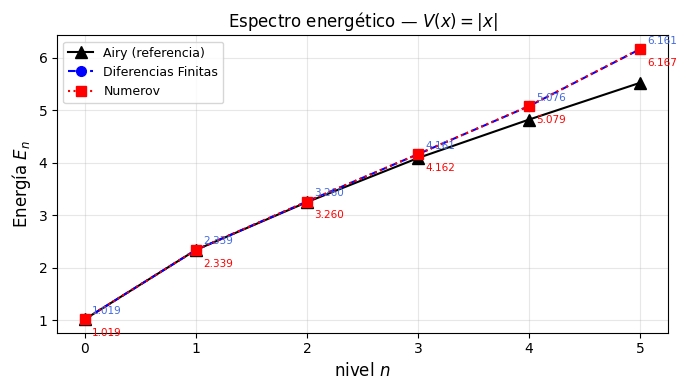

In [24]:
# ── Gráfica: espectro de energías ─────────────────────────────────────────────
N_lev = min(len(E_num_vals), len(E_fd), 6)
n_arr = np.arange(N_lev)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(n_arr, E_airy[:N_lev],      "k^-",  lw=1.5, ms=8, label="Airy (referencia)")
ax.plot(n_arr, E_fd[:N_lev],        "bo--", lw=1.5, ms=7, label="Diferencias Finitas")
ax.plot(n_arr, E_num_vals[:N_lev],  "rs:",  lw=1.5, ms=7, label="Numerov")

for n in n_arr:
    ax.annotate(f"{E_fd[n]:.3f}",      (n, E_fd[n]),       xytext=(5,  4), textcoords="offset points", fontsize=7.5, color="royalblue")
    ax.annotate(f"{E_num_vals[n]:.3f}",(n, E_num_vals[n]), xytext=(5, -12), textcoords="offset points", fontsize=7.5, color="red")

ax.set_xlabel("nivel $n$", fontsize=12)
ax.set_ylabel("Energía $E_n$", fontsize=12)
ax.set_title(r"Espectro energético — $V(x)=|x|$", fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(n_arr)
plt.tight_layout()
plt.show()


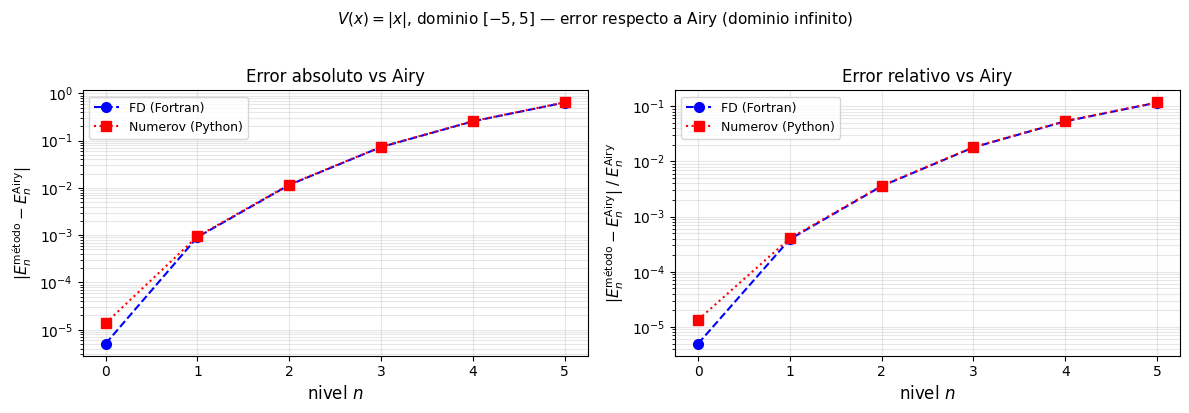

In [27]:
# ── Gráfica de errores ────────────────────────────────────────────────────────
N_lev = min(len(E_num_vals), len(E_fd), 6)
n_arr = np.arange(N_lev)

err_fd  = np.abs(E_fd[:N_lev]       - E_airy[:N_lev])
err_num = np.abs(E_num_vals[:N_lev] - E_airy[:N_lev])
err_rel_fd  = err_fd  / E_airy[:N_lev]
err_rel_num = err_num / E_airy[:N_lev]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Error absoluto
ax1.semilogy(n_arr, err_fd,  "bo--", lw=1.5, ms=7, label="FD (Fortran)")
ax1.semilogy(n_arr, err_num, "rs:",  lw=1.5, ms=7, label="Numerov (Python)")
ax1.set_xlabel("nivel $n$", fontsize=12)
ax1.set_ylabel(r"$|E_n^{\rm método} - E_n^{\rm Airy}|$", fontsize=11)
ax1.set_title("Error absoluto vs Airy", fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, which="both", alpha=0.3)
ax1.set_xticks(n_arr)

# Error relativo
ax2.semilogy(n_arr, err_rel_fd,  "bo--", lw=1.5, ms=7, label="FD (Fortran)")
ax2.semilogy(n_arr, err_rel_num, "rs:",  lw=1.5, ms=7, label="Numerov (Python)")
ax2.set_xlabel("nivel $n$", fontsize=12)
ax2.set_ylabel(r"$|E_n^{\rm método} - E_n^{\rm Airy}|\;/\;E_n^{\rm Airy}$", fontsize=11)
ax2.set_title("Error relativo vs Airy", fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, which="both", alpha=0.3)
ax2.set_xticks(n_arr)

plt.suptitle(r"$V(x)=|x|$, dominio $[-5,5]$ — error respecto a Airy (dominio infinito)",
             fontsize=11, y=1.02)
plt.tight_layout()
plt.show()


## 5. Tiempos de ejecución — FD vs Numerov

Método                           Mediana (ms)   Desv. std (ms)  Notas
────────────────────────────────────────────────────────────────────────────────
FD Fortran  (N = 50 → 1 000)          2605.27          1172.51  Fortran -O2, barrido completo
Numerov Python  (3 000 pts)          84981.56          6194.83  Python puro, 8 000 energías

Numerov es 32.6× más lento que FD  (mediana de 3 ejecuciones)


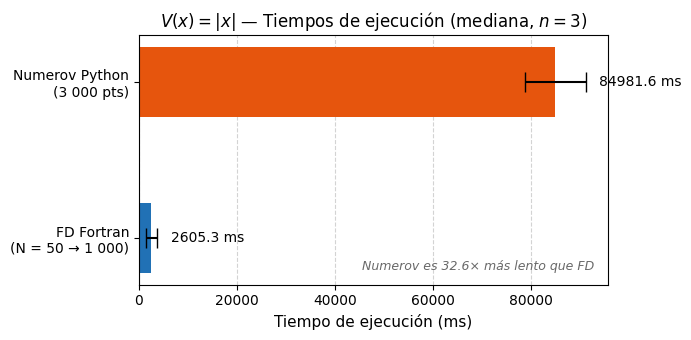

In [28]:
import time

N_rep = 3  # repeticiones para mediana robusta

# ── 1. FD Fortran (barrido N = 50 → 1000) ────────────────────────────────────
t_fd_runs = []
for _ in range(N_rep):
    t0 = time.perf_counter()
    subprocess.run("./pot_abs_fd", shell=True, capture_output=True)
    t_fd_runs.append(time.perf_counter() - t0)

t_fd_med = np.median(t_fd_runs) * 1e3   # ms
t_fd_std = np.std(t_fd_runs)    * 1e3

# ── 2. Numerov Python (barrido E + bisección, 3000 pts) ───────────────────────
def _run_numerov():
    pe = np.array([numerov(E, x_num, V_num)[-1] for E in E_scan])
    found = 0
    for i in range(len(pe) - 1):
        if pe[i] * pe[i + 1] < 0:
            biseccion(E_scan[i], E_scan[i + 1], x_num, V_num)
            found += 1
            if found == 6:
                break

t_num_runs = []
for _ in range(N_rep):
    t0 = time.perf_counter()
    _run_numerov()
    t_num_runs.append(time.perf_counter() - t0)

t_num_med = np.median(t_num_runs) * 1e3
t_num_std = np.std(t_num_runs)    * 1e3

# ── Tabla ─────────────────────────────────────────────────────────────────────
factor = t_num_med / t_fd_med
cmp_str = f"Numerov es {factor:.1f}× {'más lento' if factor > 1 else 'más rápido'} que FD"

print(f"{'Método':<30} {'Mediana (ms)':>14} {'Desv. std (ms)':>16}  Notas")
print("─" * 80)
print(f"{'FD Fortran  (N = 50 → 1 000)':<30} {t_fd_med:>14.2f} {t_fd_std:>16.2f}  Fortran -O2, barrido completo")
print(f"{'Numerov Python  (3 000 pts)':<30} {t_num_med:>14.2f} {t_num_std:>16.2f}  Python puro, 8 000 energías")
print(f"\n{cmp_str}  (mediana de {N_rep} ejecuciones)")

# ── Gráfica ───────────────────────────────────────────────────────────────────
labels     = ["FD Fortran\n(N = 50 → 1 000)", "Numerov Python\n(3 000 pts)"]
t_meds_arr = [t_fd_med, t_num_med]
t_stds_arr = [t_fd_std, t_num_std]
colors     = ["#2171b5", "#e6550d"]

fig, ax = plt.subplots(figsize=(7, 3.5))
bars = ax.barh(labels, t_meds_arr, xerr=t_stds_arr, color=colors, height=0.45,
               error_kw=dict(ecolor="black", lw=1.5, capsize=7), zorder=2)
ax.set_xlabel("Tiempo de ejecución (ms)", fontsize=11)
ax.set_title(r"$V(x) = |x|$ — Tiempos de ejecución (mediana, $n=" + str(N_rep) + r"$)",
             fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.55, zorder=1)

offset = max(t_stds_arr) * 0.3 + max(t_meds_arr) * 0.01
for bar, t, s in zip(bars, t_meds_arr, t_stds_arr):
    ax.text(t + s + offset, bar.get_y() + bar.get_height() / 2,
            f"{t:.1f} ms", va="center", fontsize=10)

ax.annotate(cmp_str, xy=(0.97, 0.06), xycoords="axes fraction",
            ha="right", fontsize=9, color="dimgray", style="italic")
ax.set_xlim(left=0)
plt.tight_layout()
plt.show()
